In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

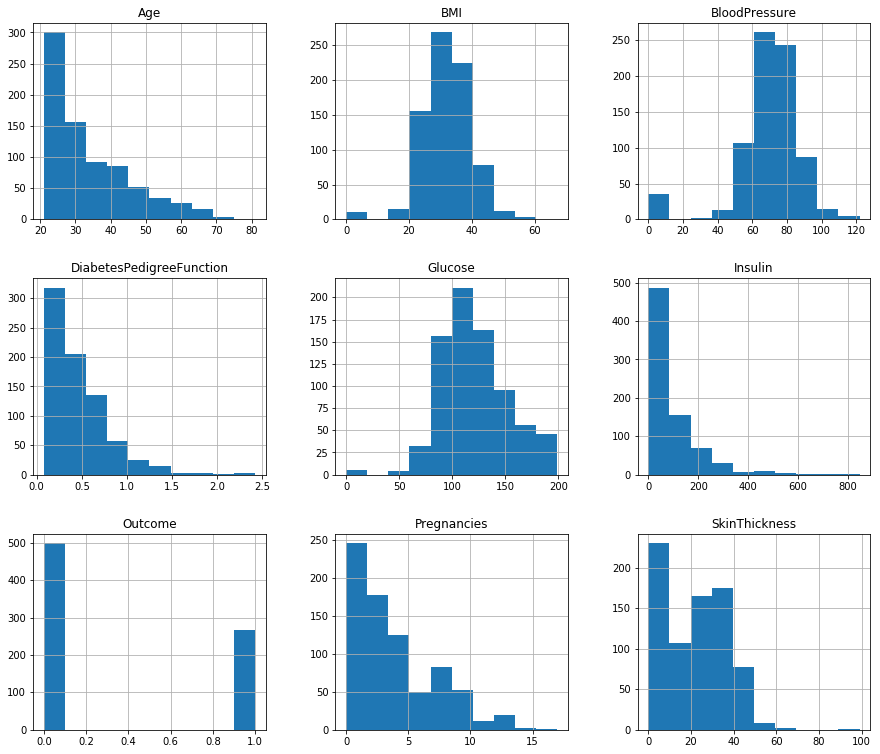

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
"""了解数据集中各项数据的分布"""
dataset = pd.read_csv("diabetes.csv")
dataset.hist(figsize = (15, 13))
plt.show()
dataset.head(5)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
"""了解数据集中各项数据的分布"""
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
"""数据预处理"""
"""将Glucose、BloodPressure、SkinThickness、Insulin、BMI的0值全部替换为NAN"""
lst = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
dataset_copy = dataset.copy(deep = True)     #深复制
dataset_copy[lst] = dataset_copy[lst].replace(0, np.NAN)
dataset_copy.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [6]:
"""计算每列数据基于不同标签结果的平均值"""
def mean_byoutcome(dataname):
    data = dataset_copy[dataset_copy[dataname].notnull()]
    data = data[[dataname,'Outcome']].groupby('Outcome').mean()
    return data

In [7]:
"""将计算好的数据填充至相应位置"""
for item in lst:
    dataset_copy.loc[(dataset_copy[item].isnull()) & (dataset_copy['Outcome'] == 0), item] = mean_byoutcome(item)[item][0]
    dataset_copy.loc[(dataset_copy[item].isnull()) & (dataset_copy['Outcome'] == 1), item] = mean_byoutcome(item)[item][1]

In [8]:
dataset_copy.isnull().any()     #检查数据集，确认是否还有缺失值

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [9]:
"""数据标准化,对除了结果列的其他列数据做标准化处理"""
zscore = preprocessing.StandardScaler()     #建立StandardScaler对象
df = pd.DataFrame(zscore.fit_transform(dataset_copy.drop(['Outcome'], axis = 1)),columns =\
                  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.864020,-0.035389,0.645088,0.561272,0.167806,0.468492,1.425995
1,-0.844885,-1.205478,-0.531332,-0.027701,-0.300842,-0.850452,-0.365061,-0.190672
2,1.233880,2.013741,-0.696647,0.420825,0.561272,-1.330487,0.604397,-0.105584
3,-0.844885,-1.074081,-0.531332,-0.700491,-0.709475,-0.632253,-0.920763,-1.041549
4,-1.141852,0.502679,-2.680419,0.645088,0.123830,1.549727,5.484909,-0.020496


In [10]:
num = dataset_copy.Outcome.value_counts()     #查看数据集中患病人数和未患病人数
print(num)
print('糖尿病患病率为{:.2f}%'.format(num[1] / dataset_copy.shape[0] * 100))

0    500
1    268
Name: Outcome, dtype: int64
糖尿病患病率为34.90%


In [11]:
"""构建模型，划分数据集"""
x = df
y = dataset_copy.Outcome
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [12]:
"""选择随机森林算法训练模型并进行预测"""
#选择信息增益来衡量分裂好坏，设置森林里有200棵树，树的深度为12，至少12个样本的情况下才继续分叉
rf = RandomForestClassifier(criterion='entropy', n_estimators = 200, max_depth = 12, min_samples_split = 12)
rf.fit(x_train, y_train)     #训练模型
y_predict = rf.predict(x_test)     #预测
print(f"Accuracy:{metrics.accuracy_score(y_test, y_predict)}")

Accuracy:0.8571428571428571


In [13]:
num_0 = np.sum(y_predict == 0)
num_1 = np.sum(y_predict == 1)
print('预测的糖尿病患病率为{:.2f}%'.format(num_1 / (num_0 + num_1) * 100))

预测的糖尿病患病率为34.20%


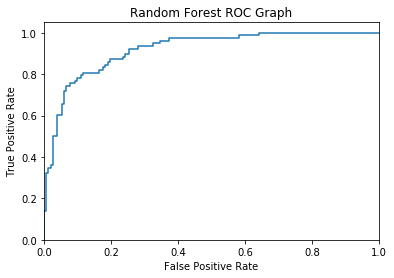

In [14]:
"""画ROC图"""
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, rf.predict_proba(x_test)[:, 1])
plt.figure()
plt.plot(rf_fpr, rf_tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Graph')
plt.show()